In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
import geopandas as gpd
import xgboost as xgb
from sklearn.model_selection import train_test_split


embedding_dataset = gpd.read_parquet("/home/christopher.x.ren/datasets/ra_tea/tile_classifier_dataset_v2_java-sumatra_embeddings.parquet").reset_index(drop=True)
print(embedding_dataset.shape)
feature_cols = [col for col in embedding_dataset.columns if 'vit' in col]
X = embedding_dataset[feature_cols]
y = embedding_dataset['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, 
    random_state=42,
    stratify=embedding_dataset['class']
)

# Train XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42, n_jobs=-1
)
model.fit(X_train, y_train)

# Get training and test accuracy
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")


(210409, 388)


Training accuracy: 1.000
Test accuracy: 0.994


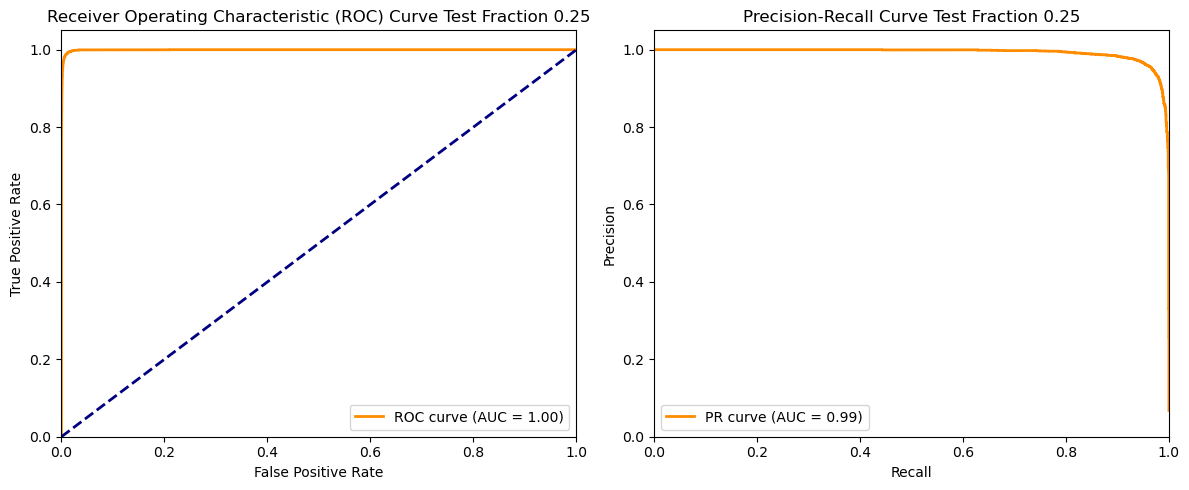

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics

# Get predictions and probabilities
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Calculate ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)

# Calculate PR curve
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
pr_auc = metrics.average_precision_score(y_test, y_pred_proba)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve Test Fraction 0.25')
ax1.legend(loc="lower right")

# Plot PR curve
ax2.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve Test Fraction 0.25')
ax2.legend(loc="lower left")

plt.tight_layout()
plt.savefig('roc_pr_curves.png', dpi=100)


In [20]:
# Calculate classification metrics
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}") 
print(f"F1 Score: {f1:.3f}")


Precision: 0.963
Recall: 0.954
F1 Score: 0.958


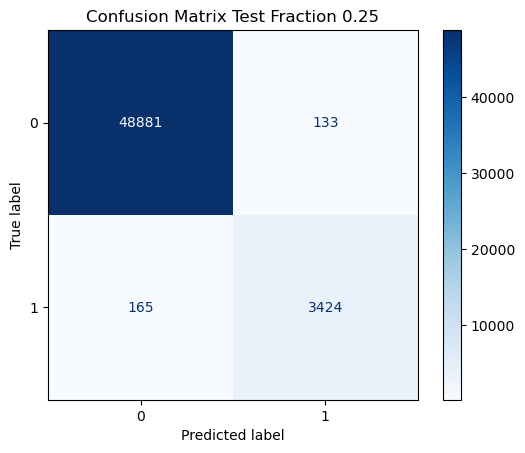

In [21]:
# Calculate and plot confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix Test Fraction 0.25')
plt.savefig('confusion_matrix_test_fraction_0.25.png', dpi=100)


100%|██████████| 50/50 [00:01<00:00, 40.84it/s]
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:  3.2min remaining: 49.5min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:  3.2min remaining: 14.5min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:  3.2min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:  3.3min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:  3.3min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:  5.1min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:  5.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  5.8min remaining:   38.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.8min finished


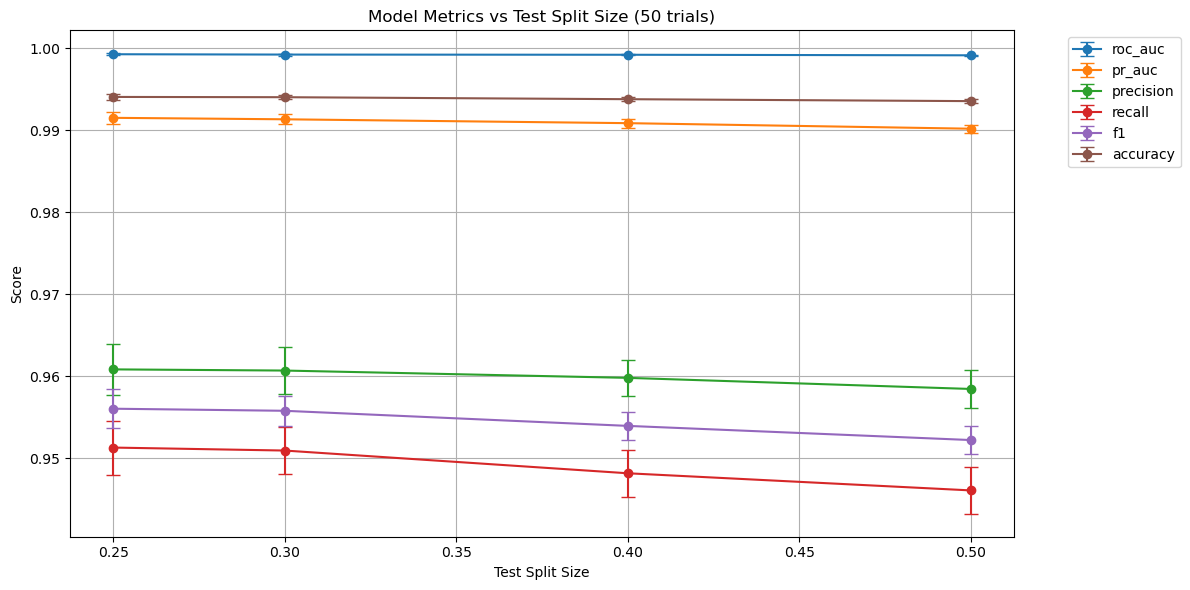

In [11]:
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

def run_trial(trial, test_splits, X, y, model):
    trial_results = {}
    for test_size in test_splits:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=trial)
        
        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
        precision_curve, recall_curve, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
        
        trial_results[test_size] = {
            'roc_auc': metrics.roc_auc_score(y_test, y_pred_proba),
            'pr_auc': metrics.auc(recall_curve, precision_curve),
            'precision': metrics.precision_score(y_test, y_pred),
            'recall': metrics.recall_score(y_test, y_pred),
            'f1': metrics.f1_score(y_test, y_pred),
            'accuracy': metrics.accuracy_score(y_test, y_pred)
        }
    return trial_results

test_splits = [0.5, 0.4, 0.3, 0.25]
n_trials = 50

# Run trials in parallel
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_trial)(trial, test_splits, X, y, model) 
    for trial in tqdm(range(n_trials))
)

# Reorganize results
metrics_dict = {split: [] for split in test_splits}
for trial_result in results:
    for test_size, metrics_values in trial_result.items():
        metrics_dict[test_size].append(metrics_values)

# Calculate means and standard deviations
mean_metrics = []
std_metrics = []

for test_size in test_splits:
    trial_df = pd.DataFrame(metrics_dict[test_size])
    mean_metrics.append({
        'test_split': test_size,
        **trial_df.mean().to_dict()
    })
    std_metrics.append(trial_df.std().to_dict())

# Create DataFrames
df_mean = pd.DataFrame(mean_metrics).set_index('test_split')
df_std = pd.DataFrame(std_metrics, index=test_splits)

# Plot with error bars
plt.figure(figsize=(12, 6))
for column in df_mean.columns:
    plt.errorbar(test_splits, df_mean[column], yerr=df_std[column], 
                marker='o', label=column, capsize=5)

plt.title('Model Metrics vs Test Split Size (50 trials)')
plt.xlabel('Test Split Size')
plt.ylabel('Score')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig('model_metrics_vs_test_split_size.png', dpi=100)
